# Challange:Food-101 DataSet

**Food-101** is a challenging vision problem, but everyone can relate to it. Recent SoTA is ~80% top-1, 90% top-5. These approaches rely on lots of TTA, large networks and even novel architecture

# InceptionV3

The Inception network was an important milestone in the development of CNN classifiers. Prior to its inception most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.The Inception network on the other hand, was complex (heavily engineered). It used a lot of tricks to push performance; both in terms of speed and accuracy. Its constant evolution lead to the creation of several versions of the network.

**Introduction:**
**Inception v3** is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concats, dropouts, and fully connected layers. Batchnorm is used extensively throughout the model and applied to activation inputs. Loss is computed via Softmax.

**Architecture**
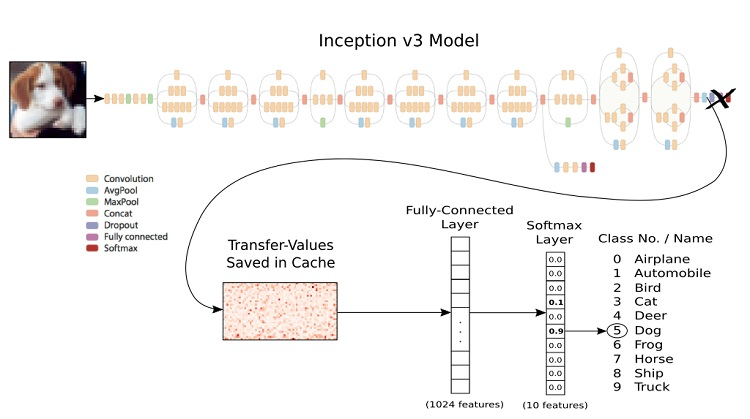

**Approach:**
Our objective is to classify 101,000 food images in 101 categories.This is very so ImageNet like where we had 1.2 million images to classify into 1000 categories.
We will use InceptionV3 as base architecture.
We will use InceptionV3 architecture which requires 299 x 299 image size as input using ImageDataGenerator from keras to create training and validation data sets.
Take a 10 random classes in which each classes has a 750 train images and 250 test images.
Architecture is  trained for 10 epochs using 10 classes for 10000 images.
Finetune the model freeze 299 bottom layers and unfreeze top 299 layers and train for another 5 epochs.


**Result*
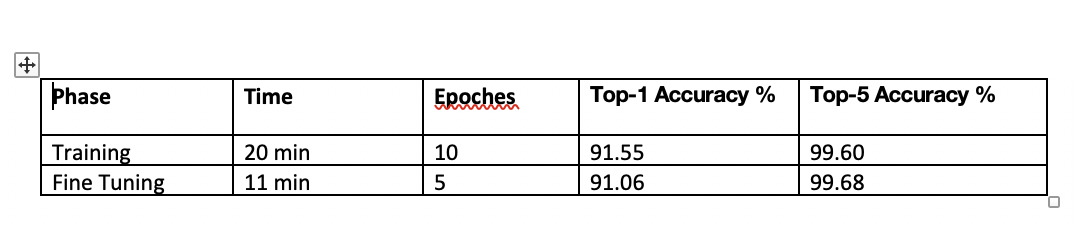


**Problem Faced**:
First i tried to train all 100000 images but it was taking more than 1 day to train and trainig accuracy was too low.The augmentation part was tricky and it requires a lots of memory.For this whole dataset it requires more than 5 GPUS and 16 GB of RAM and also google colab was to slow and for training.



**KERAS**

In [ ]:
####Importing libraries of Keras and Tensorflow 
import numpy as np
import sys
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from shutil import copytree, rmtree
from keras import applications
from keras.models import Sequential,Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import Dropout,Input
from tensorflow.contrib.keras.api.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation
from tensorflow.contrib.keras import backend
from keras.optimizers import Adam,RMSprop,SGD
from keras import optimizers
from keras.metrics import categorical_accuracy
from pathlib import Path
from tensorflow.keras.preprocessing import image
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input
import collections
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D

In [2]:
####Class Distribution of Dataset which implies that how much images has in each class.

path = Path('../input/images')

files = os.listdir(path)

#files.remove('.DS_Store')

num_classes = len(files)
print ('Number of classes:', num_classes)

dist = dict()
# class distribution
for f in files:
    dist[f] = len(os.listdir(path/f))

print ('Class distribution:')
print (dist)

Number of classes: 101
Class distribution:
{'baklava': 1000, 'chicken_wings': 1000, 'lobster_roll_sandwich': 1000, 'pulled_pork_sandwich': 1000, 'edamame': 1000, 'tuna_tartare': 1000, 'french_toast': 1000, 'tacos': 1000, 'pad_thai': 1000, 'escargots': 1000, 'fried_rice': 1000, 'beet_salad': 1000, 'omelette': 1000, 'poutine': 1000, 'falafel': 1000, 'pork_chop': 1000, 'filet_mignon': 1000, 'oysters': 1000, 'nachos': 1000, 'cup_cakes': 1000, 'lasagna': 1000, 'foie_gras': 1000, 'deviled_eggs': 1000, 'chicken_quesadilla': 1000, 'dumplings': 1000, 'ceviche': 1000, 'takoyaki': 1000, 'scallops': 1000, 'pho': 1000, 'ice_cream': 1000, 'lobster_bisque': 1000, 'samosa': 1000, 'caprese_salad': 1000, 'bread_pudding': 1000, 'spaghetti_carbonara': 1000, 'risotto': 1000, 'red_velvet_cake': 1000, 'bruschetta': 1000, 'guacamole': 1000, 'bibimbap': 1000, 'grilled_salmon': 1000, 'grilled_cheese_sandwich': 1000, 'gyoza': 1000, 'ramen': 1000, 'creme_brulee': 1000, 'steak': 1000, 'beef_tartare': 1000, 'croque

## Train and Test Split of Dataset

The main and important thing is train and test split.Each directory has 750 images of train which are very noisy and test 250 images.Each classes has 1000 images with pixel size 512.Now i split those data from directories using copytree funtion.This function i found from github.This function go to each directories and 

In [3]:
if not os.path.isdir('../input/images/test') and not os.path.isdir('../input/images/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('../input/meta/meta/train.txt')
    test_dir_files = generate_dir_file_map('../input//meta/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('../input/images', '../test', ignore=ignore_train)
    copytree('../input/images', '../train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

../input/images
../input/images/baklava
../input/images/chicken_wings
../input/images/lobster_roll_sandwich
../input/images/pulled_pork_sandwich
../input/images/edamame
../input/images/tuna_tartare
../input/images/french_toast
../input/images/tacos
../input/images/pad_thai
../input/images/escargots
../input/images/fried_rice
../input/images/beet_salad
../input/images/omelette
../input/images/poutine
../input/images/falafel
../input/images/pork_chop
../input/images/filet_mignon
../input/images/oysters
../input/images/nachos
../input/images/cup_cakes
../input/images/lasagna
../input/images/foie_gras
../input/images/deviled_eggs
../input/images/chicken_quesadilla
../input/images/dumplings
../input/images/ceviche
../input/images/takoyaki
../input/images/scallops
../input/images/pho
../input/images/ice_cream
../input/images/lobster_bisque
../input/images/samosa
../input/images/caprese_salad
../input/images/bread_pudding
../input/images/spaghetti_carbonara
../input/images/risotto
../input/im

Now,for the faster traing i made  mini dataset which has 10 randomly choosen classes.

In [19]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [20]:
food_list = ['apple_pie','pizza','omelette','scallops','tacos','nachos','oysters','pork_chop','cup_cakes','pho']
src_train = '../train'
dest_train = 'train_mini'
src_test = '../test'
dest_test = 'test_mini'

In [21]:
dataset_mini(food_list, src_train, dest_train)

Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into scallops
Copying images into tacos
Copying images into nachos
Copying images into oysters
Copying images into pork_chop
Copying images into cup_cakes
Copying images into pho


In [22]:
dataset_mini(food_list, src_test, dest_test)

Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into scallops
Copying images into tacos
Copying images into nachos
Copying images into oysters
Copying images into pork_chop
Copying images into cup_cakes
Copying images into pho


## Data Augmentation Part:

Here,the data augmentation part is most important part in the training.Because,Each images has a different augmentation and pixel values for make model more accurate we need to augment all the images into same size.So in keras image data generator take each directories as input take images and then use flip,rotation rescale and all data augmentation technique and make image more clean and noiseless.

In [23]:
batch_size = 16
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect',
    )
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = datagen.flow_from_directory('train_mini',
                                              target_size=(299, 299),
                                              batch_size=batch_size,
                                              #subset='training',
                                              class_mode='categorical')

val_generator = datagen.flow_from_directory('test_mini',
                                            target_size=(299, 299),
                                            batch_size=batch_size,
                                            #subset='training',
                                            class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## **Training**

Now,For trainig i use InceptionV3 model and their weights.In the pre training  models the weights are most important things to use.For the trainig we can use pre trained models weights to our dataset and classifies the images according to their classes.In InceptionV3 they have many no of layers and their weights which has got more than 88% accuracy as per study.So we are using their weights to train model of this data.I use global average pooling as top layer and then regularizers to prevent overfitting of data.In most of case overfitting happend because model has to many layers which make model too compex.In the last layer i use softmax activation function because this data is multi class categorical so softmax is effective function for the categorical data.

Avoiding overfitting i use L2 norm regularizer.Which add lambda and make squared root of weights.To reduce complexity of model i used dense layer beacuse they remove unneccesary nodes from the layer.

In the trained i traind images with batch size of 16 till 10 epoches.I am able to achive **91.55% top-1 accurcy and 99.60% top-5 accuracy.**

While training i was also focusing on loss function becasue RMSProp,SGD,Adamx,AdaDelta,Adagrad i tried almost every optimizers but SGD works for me.The reason behind this is batch ,momentum and learning rate.

In [68]:
k=5
base_model =InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers[:]:
    layer.trainable = False 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(10,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy','top_k_categorical_accuracy'])

In [61]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, None, None, 3 96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, None, None, 3 0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_566

In [44]:
history=model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples// batch_size,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // batch_size,
                              #callbacks=[mc, es]
                    
                              #shuffle=True,
                              #use_multiprocessing=True,
                              

)

Epoch 1/10
468/468 [==============================] - 218s 466ms/step - loss: 0.5443 - acc: 0.8549 - top_k_categorical_accuracy: 0.9901 - val_loss: 0.4421 - val_acc: 0.8897 - val_top_k_categorical_accuracy: 0.9956
Epoch 2/10
468/468 [==============================] - 215s 459ms/step - loss: 0.5154 - acc: 0.8627 - top_k_categorical_accuracy: 0.9904 - val_loss: 0.4278 - val_acc: 0.8933 - val_top_k_categorical_accuracy: 0.9968
Epoch 3/10
468/468 [==============================] - 214s 458ms/step - loss: 0.5044 - acc: 0.8638 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.3884 - val_acc: 0.9050 - val_top_k_categorical_accuracy: 0.9944
Epoch 4/10
468/468 [==============================] - 211s 452ms/step - loss: 0.4716 - acc: 0.8819 - top_k_categorical_accuracy: 0.9924 - val_loss: 0.3912 - val_acc: 0.8998 - val_top_k_categorical_accuracy: 0.9956
Epoch 5/10
468/468 [==============================] - 211s 452ms/step - loss: 0.4559 - acc: 0.8829 - top_k_categorical_accuracy: 0.9929 - val_lo

In [185]:
score=model.evaluate_generator(val_generator,steps=50)
print("Accuracy after 50 steps",score[1]*100)

Accuracy after 50 steps 93.25


For checking my model i took two random train images from Daase.

In [130]:
images=image.load_img('../input/images/apple_pie/1005649.jpg')
images2=image.load_img('../input/images/apple_pie/1011328.jpg')

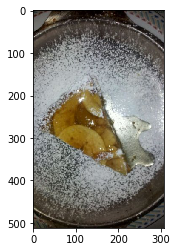

In [135]:
plt.imshow(images)

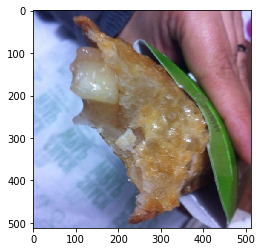

In [136]:
plt.imshow(images2)

Classifies both images using Inceptionv3 model.

In [122]:
def predict_food(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    prediction = model.predict(img)
    index = np.argmax(prediction)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

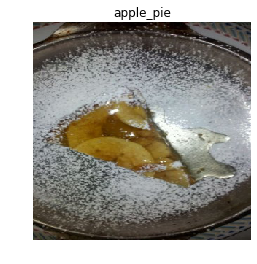

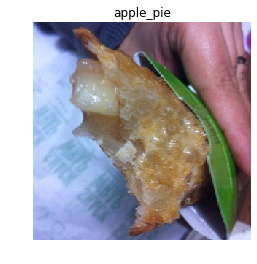

In [179]:
test_images = []
test_images.append('../input/images/apple_pie/1005649.jpg')
test_images.append('../input/images/apple_pie/1011328.jpg')


predict_food(model, test_images, True)


In [63]:
model.save('model.h5')

## Visulization of Accuracy and loss.

In [57]:
from matplotlib import pyplot

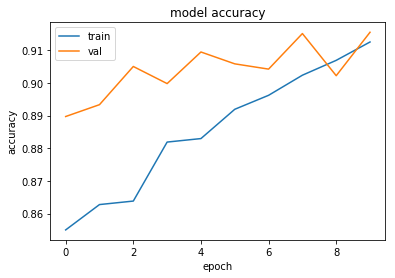

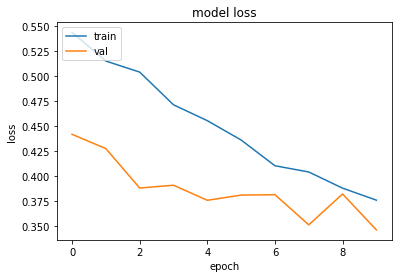

In [103]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

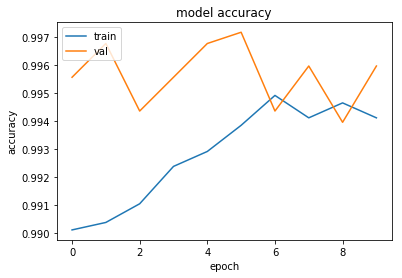

In [104]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## FineTuning

In [86]:
from keras.models import Model, load_model, Sequential

I just load model  and freeze the bottom 299 layers and unfreeze top 299 layers.Which redeuce no of layers in the model and i am able to get **91.06% top 1 accuracy and 99.68% top-5 accuracy in just 5 epoches.**


In [95]:
model=load_model('model.h5')
for layer in model.layers[:299]:
    layer.trainable = False
for layer in model.layers[299:]:
    layer.trainable = True  

In [96]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy','top_k_categorical_accuracy'])

In [102]:
finetune_model=model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples// batch_size,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // batch_size,
                              #callbacks=[mc, es]
                    
                              #shuffle=True,
                              #use_multiprocessing=True,
                              
)

Epoch 1/5
468/468 [==============================] - 197s 422ms/step - loss: 0.3561 - acc: 0.9134 - top_k_categorical_accuracy: 0.9971 - val_loss: 0.3746 - val_acc: 0.9078 - val_top_k_categorical_accuracy: 0.9948
Epoch 2/5
468/468 [==============================] - 195s 416ms/step - loss: 0.3505 - acc: 0.9140 - top_k_categorical_accuracy: 0.9966 - val_loss: 0.3516 - val_acc: 0.9171 - val_top_k_categorical_accuracy: 0.9952
Epoch 3/5
468/468 [==============================] - 195s 416ms/step - loss: 0.3479 - acc: 0.9180 - top_k_categorical_accuracy: 0.9969 - val_loss: 0.3543 - val_acc: 0.9118 - val_top_k_categorical_accuracy: 0.9976
Epoch 4/5
468/468 [==============================] - 195s 417ms/step - loss: 0.3470 - acc: 0.9189 - top_k_categorical_accuracy: 0.9963 - val_loss: 0.3625 - val_acc: 0.9098 - val_top_k_categorical_accuracy: 0.9940
Epoch 5/5
468/468 [==============================] - 193s 413ms/step - loss: 0.3399 - acc: 0.9202 - top_k_categorical_accuracy: 0.9961 - val_loss: 0

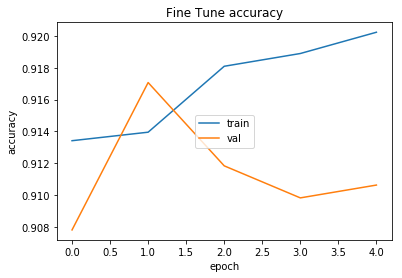

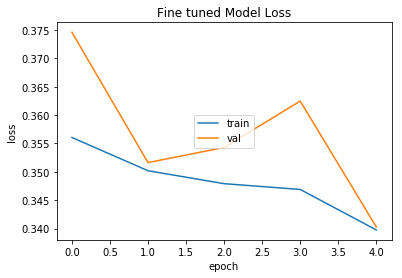

In [105]:
plt.plot(finetune_model.history['acc'])
plt.plot(finetune_model.history['val_acc'])
plt.title('Fine Tune accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')
plt.show()
plt.plot(finetune_model.history['loss'])
plt.plot(finetune_model.history['val_loss'])
plt.title('Fine tuned Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')
plt.show()

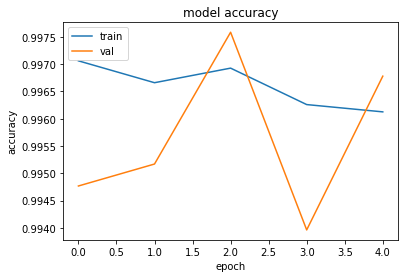

In [106]:
plt.plot(finetune_model.history['top_k_categorical_accuracy'])
plt.plot(finetune_model.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()